# KaRMMa Demo

This demo notebook shows the basics of using KaRMMa and some of its built in utilities.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import karmma
import pickle

## Generating a Mock

We'll first start by generating a mock observation to run KaRMMa on. We'll load up the survey mask, power spectrum, and lognormal shift parameter that we will use for our mock. We then plot the survey mask below.

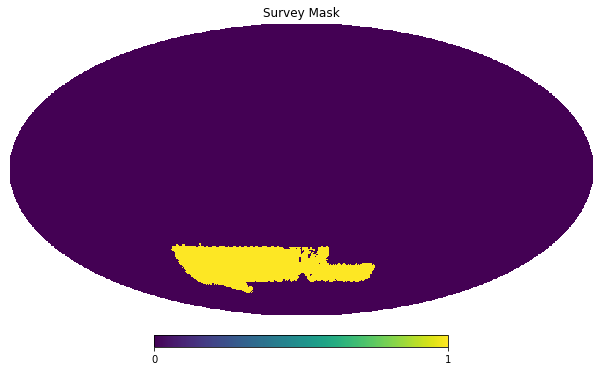

In [2]:
# Set the healpix resolution and ell cut.
nside = 128
lmax = 256

# Load the mask, shift, and power spectrum of the convergence field.
data = pickle.load(open('demo_data.p', 'rb'))
mask = data['mask']
shift = data['shift']
cl = data['cl']

# Visualize the mask
hp.mollview(mask, title='Survey Mask')

To minimize masking effects, we will perform the reconstruction on the mask with a buffer region. Here, we will use a buffer region of 5 pixels. We can generate the buffered mask using an included KaRMMa utility.

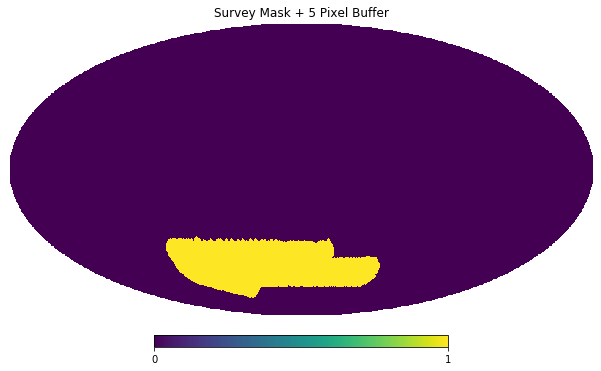

In [3]:
# Add 5 pixels of buffer around the mask.
bmask = karmma.utils.add_buffer(mask, 5)

# Visualize the buffered mask.
hp.mollview(bmask, title='Survey Mask + 5 Pixel Buffer')

Now we will generate a simulated weak lensing map. We first compute the pixelized power spectrum, then we transform the power spectrum of the convergence field to the power spectrum of the log-convergence where the field is Gaussian. Next, we generate a lognormal convergence field and use the Kaiser-Squires transform to get the shear field. The fields are visualized below.

_Note_: In this demo we're assuming that the true convergence field only has power up to the well resolved mode, $\ell_\mathrm{max}$. In reality, the true convergence field will have modes out to $\ell = \infty$. For simplicity, we ignore these modes in this demo, however they can be dealt with as detailed in the paper.

/home/pierfied/opt/anaconda3/envs/karmma/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


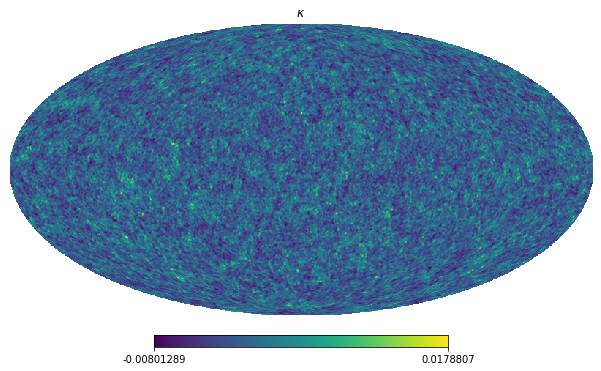

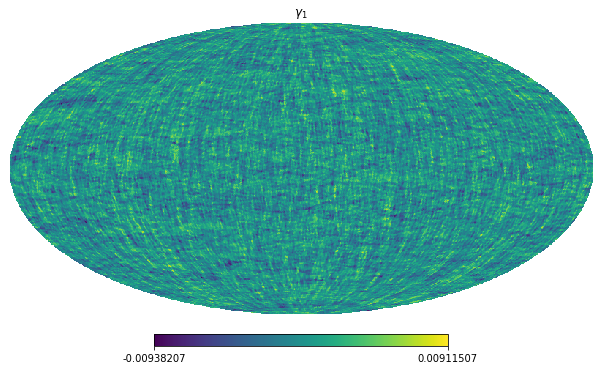

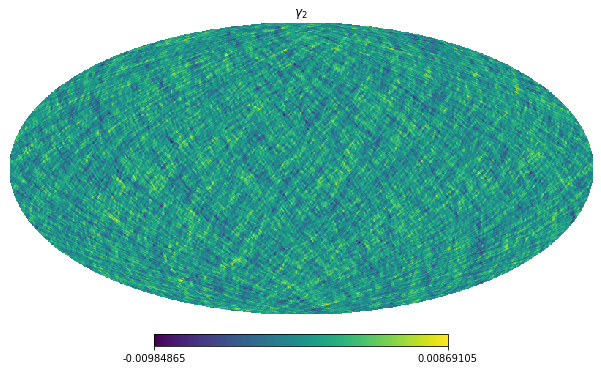

In [4]:
# Apply the pixel window function to the convergence power spectrum.
pw = hp.pixwin(nside, lmax=lmax)
cl_pw = cl * (pw ** 2)

# Compute the power spectrum and mean of the log-convergence field.
gauss_cl = karmma.utils.lognorm_to_gauss_cl(cl_pw, shift, lmax=lmax)
gauss_var = karmma.utils.cl2xi_theta(gauss_cl, 0)
mu = np.log(shift) - 0.5 * gauss_var

# Produce a lognormal mock.
k = np.exp(mu + hp.synfast(gauss_cl, nside)) - shift

# Apply the Kaiser-Squires transformation to get the shear field.
g1, g2 = karmma.utils.conv2shear(k, lmax=lmax)

# Visualize the maps.
hp.mollview(k, title='$\\kappa$')
hp.mollview(g1, title='$\\gamma_1$')
hp.mollview(g2, title='$\\gamma_2$')

Now we'll generate an observed shear map by adding shape noise to the true shear field and applying the survey mask. We'll assume that the shape noise has the same variance as the field itself.

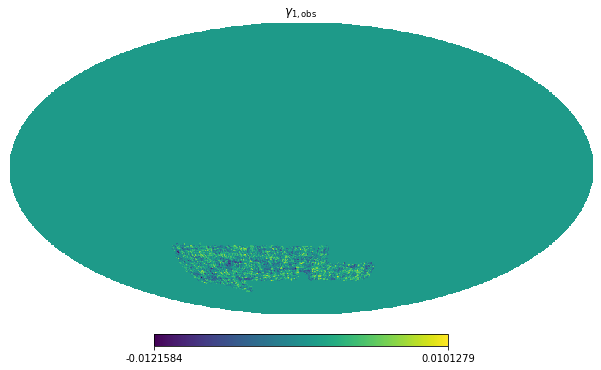

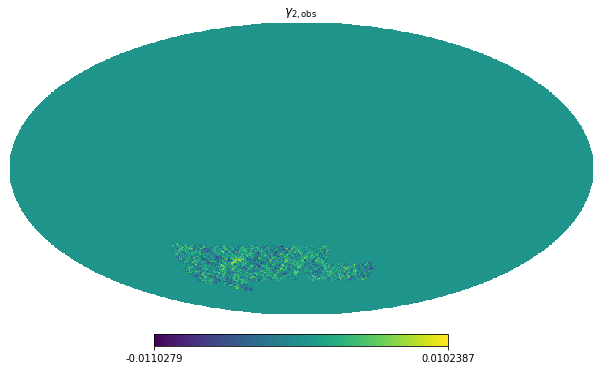

In [5]:
# Assume the shape noise has the same variance as the shear field.
sigma_sn = g1.std()

# Add the shape noise.
g1_obs = (g1 + np.random.standard_normal(len(g1)) * sigma_sn) * mask
g2_obs = (g2 + np.random.standard_normal(len(g2)) * sigma_sn) * mask

# Visualize the maps.
hp.mollview(g1_obs, title='$\\gamma_{1,\mathrm{obs}}$')
hp.mollview(g2_obs, title='$\\gamma_{2,\mathrm{obs}}$')

## Preparing KaRMMa Inputs

We now turn to generating some of the required inputs for KaRMMa. To do this, we will use several of the utilities provided with KaRMMa. Specifically, we will need to generate the prior covariance matrix, the matrices for performing the Kaiser-Squires transformation, and the shape noise covariance matrices.

We'll start by creating the lognormal prior covariance matrix for all pixels in the buffered mask. We then diagonalize the prior covariance matrix using SVD. Plotted below are the singular values of the covariance matrix (normalized by the largest singular value).

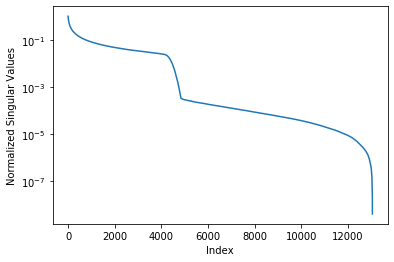

In [6]:
# Create the covariance matrix for the lognormal prior over the buffered mask.
cov = karmma.utils.cl2cov_mat(cl_pw, nside, mask=bmask, lmax=lmax, log=True, shift=shift)

# Perform SVD
u, s, _ = np.linalg.svd(cov)

# Plot the singular values.
plt.semilogy(s/s[0])
plt.xlabel('Index')
plt.ylabel('Normalized Singular Values')
plt.show()

We see that the covariance matrix has a large condition number with singular values that span many orders of magnitude. Inverting this matrix as is to get the precision matrix is not numerically stable and will result in poor sampling. Note that the singular values exhibit a several order of magnitude drop at about index 5000. This is expected as we have imposed an $\ell$ cut on the convergence field. Modes beyond this index do not contribute meaningfully to the statistics of the map. Therefore, we can exclude these modes from our model and improve numerical stability. We'll truncate modes such that the condition number is less than $5 \times 10^{4}$.

In [7]:
# Set the desired condition number.
rcond = 5e-4
cut_inds = s / s[0] > rcond

# Truncate the singular modes.
u = u[:, cut_inds]
s = s[cut_inds]

Now we'll generate the Kaiser-Squires transformation matrices used in the forward modeling step of KaRMMa. Note that we modify the matrix such that applying the matrices to a vector of convergence values in the buffered mask produces vectors of shear values only in the original survey mask where our shear field is observed.

In [8]:
# Create the Kaiser-Squires transformation matrices.
k2g1, k2g2 = karmma.utils.conv2shear_mats(nside, mask=bmask, lmax=lmax)

# Create a mask that indexes the original survey mask pixels inside of the buffered mask.
mask_in_bmask = mask[bmask]

# Modify the matrices to output the shear field in the survey mask only.
k2g1 = k2g1[mask_in_bmask,:]
k2g2 = k2g2[mask_in_bmask,:]

Lastly, we need the covariance matrices for the likelihood term. In this demo we will assume that the covariance matrices are diagonal and only include the shape noise. In practice, this covariance matrix would also include the residual masking effects and high $\ell$ power (see the paper for a detailed discussion).

In [9]:
# Create the precision matrices of the shape noise for the likelihood term.
inv_noise_cov_1 = np.eye(mask.sum()) / (sigma_sn ** 2)
inv_noise_cov_2 = np.eye(mask.sum()) / (sigma_sn ** 2)

## Running KaRMMa

We are now ready to run KaRMMa on our mock dataset and generate samples from the posterior distribution. We'll start the sampler by generating 100 samples of burn-in then we'll generate a chain of 500 samples with 5 leapfrog integration steps per sample. 

*Note*: By default, KaRMMa will attempt to run on a GPU.

In [10]:
# Convert the mean value of the log-convergence field to a vector. 
# When the covariance is computed taking pixel geometry into account (see paper), the mean will differ for each pixel.
mu = np.ones(bmask.sum()) * mu

# Create the sampler object.
sampler = karmma.KarmmaSampler(g1_obs, g2_obs, mask, u, s, mu, shift, k2g1, k2g2, inv_noise_cov_1, inv_noise_cov_2, device='cpu')

# Run the sampler to generate a chain.
chain = sampler.sample(num_burn=100, num_burn_steps=1, burn_epsilon=0.15,
                       num_samples=500, num_samp_steps=5, samp_epsilon=0.1)

We can now take a look at the output chain. The chain is provided as a python list of dictionaries where each dictionary contains a sample and relevant information. Below we print out one of the samples and some relevant statistics from the chain. Note that the output sample maps (stored as 'x' in the chain) are the convergence field in the buffered mask.

First Sample:  {'x': array([ 0.0002569 , -0.00025643,  0.0048502 , ...,  0.00315945,
        0.00058966,  0.00508063], dtype=float32), 'lnP': array(-11193.999, dtype=float32), 'accpet_ratio': 1.0, 'accept_prob': 1.0, 'accepted': True} 

Chain Acceptance Rate:  0.662 



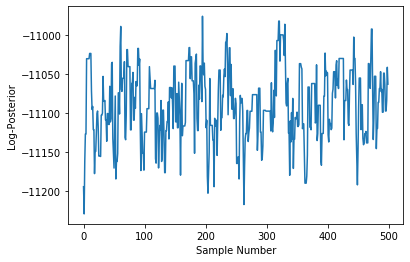

In [11]:
# Print the first sample.
print('First Sample: ', chain[0], '\n')

# Print the acceptance rate of the chain.
print('Chain Acceptance Rate: ', np.mean([samp['accepted'] for samp in chain]), '\n')

# Plot the log-posterior of the samples.
plt.plot([samp['lnP'] for samp in chain])
plt.xlabel('Sample Number')
plt.ylabel('Log-Posterior')
plt.show()

Below, we show one of the sample maps and compare it to the true map.

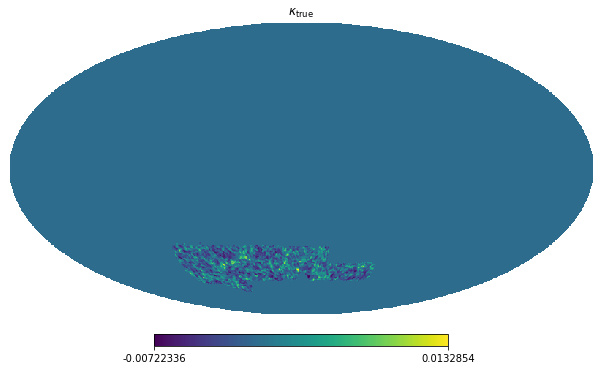

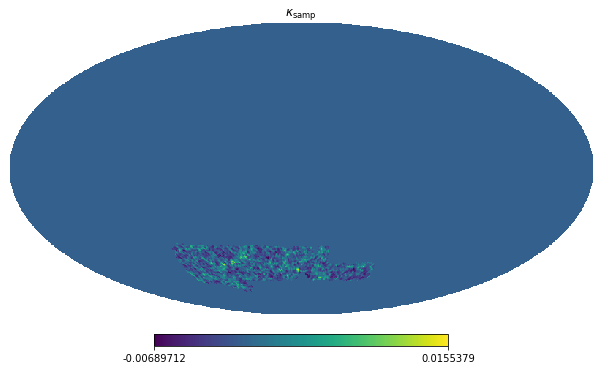

In [12]:
# Show the true map over the survey region.
hp.mollview(k * mask, title='$\\kappa_\\mathrm{true}$')

# Show the sample map over the survey region.
ksamp = np.zeros_like(k)
ksamp[bmask] = chain[-1]['x']
hp.mollview(ksamp * mask, title='$\\kappa_\\mathrm{samp}$')